In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#loading the saved training images and truth maks as numpy files
data_x_train = np.load('/content/drive/My Drive/Colab Notebooks/data_x_train.npy')
data_y_train = np.load('/content/drive/My Drive/Colab Notebooks/data_y_train.npy')

In [ ]:
print('shape of train set is' + str(np.array(data_x_train).shape))
print('shape of train ground truth set is' + str(np.array(data_y_train).shape))

shape of train set is(28, 4, 240, 240)
shape of train ground truth set is(252, 240, 240)


In [ ]:
def slice3dto2d(data_x_train):
    data_x_expnd_train = []
    for i in range(data_x_train.shape[0]):
        for j in range(data_x_train.shape[1]):
            if j == 0:
                for k in range(3):
                    data_x_expnd_train.append(data_x_train[i,j,:,:])#taking 1st image 3 times
            else:
                for l in range(2):
                    data_x_expnd_train.append(data_x_train[i,j,:,:])#taking 2nd, 3rd and 4th images 2 times each
    return data_x_expnd_train

In [ ]:
data_x_expnd_train = slice3dto2d(data_x_train)
data_x_expnd_train = np.array(data_x_expnd_train)
data_y_train1 = data_y_train
print('New shape of train set is' + str(data_x_expnd_train.shape))

New shape of train set is(252, 240, 240)


In [ ]:
def replacemask(data_y_train1):
    for i in range(data_y_train1.shape[0]):
        result = np.all((data_y_train1[i,:,:] == 0))
        if result and i%9!=0:
            data_y_train1[i,:,:] = data_y_train1[i-1,:,:]
        elif result and i%9==0:
            data_y_train1[i,:,:] = data_y_train1[i+1,:,:]
    return data_y_train1

In [ ]:
data_y_train1 = replacemask(data_y_train1)

In [ ]:
#loading the saved validation images and validation truth masks as numpy files
data_x_val = np.load('/content/drive/My Drive/Colab Notebooks/data_x_val.npy')
data_y_val = np.load('/content/drive/My Drive/Colab Notebooks/data_y_val.npy')

In [ ]:
print('shape of validation set is' + str(data_x_val.shape))
print('shape of validation ground truth set is' + str(data_y_val.shape))

shape of validation set is(3, 4, 240, 240)
shape of validation ground truth set is(27, 240, 240)


In [ ]:
data_x_expnd_val = slice3dto2d(data_x_val)
data_x_expnd_val = np.array(data_x_expnd_val)
data_y_val1 = data_y_val
print('New shape of validation set is' + str(data_x_expnd_val.shape))

New shape of validation set is(27, 240, 240)


In [ ]:
data_y_val1 = replacemask(data_y_val1)

In [ ]:
def appendtrainval(data_x_expnd_train, data_x_expnd_val):
    data = []
    count = 0
    m = data_x_expnd_train.shape[0]
    n = data_x_expnd_val.shape[0]
    for i in range(m+n):
        if i < m:
            data.append(data_x_expnd_train[i,:,:])
        else:
            data.append(data_x_expnd_val[count,:,:])
            count = count + 1
    return data

In [ ]:
data = appendtrainval(data_x_expnd_train, data_x_expnd_val)
gt = appendtrainval(data_y_train1, data_y_val1)

In [ ]:
print(np.array(data).shape)
print(np.array(gt).shape)

(279, 240, 240)
(279, 240, 240)


In [ ]:
def img_preprocess(img):
    img -= np.min(img)  # [0,?]
    img /= np.max(img)  # [0,1]
    img *= 2           # [0,2]
    return img - 1     # [-1,1]

In [ ]:
def reshp_brim(data, gt, shp):
    gt = np.array(gt).astype(np.uint8)
    data_all = []
    gt_all = []
    
    
    for i in range(np.array(data).shape[0]):
        result1 = np.zeros([shp[0],shp[1]]).astype(np.float32)
        result1[8:np.array(data).shape[1]+8,8:np.array(data).shape[2]+8] = np.array(data)[i,:,:]
        result1 = img_preprocess(result1)
        #result1 = result1.reshape(result1.shape[0],result1.shape[0],1)
        data_all.append(result1)
        
    for i in range(np.array(gt).shape[0]):
        result2 = np.zeros([shp[0],shp[1]]).astype(np.uint8)
        result2[8:np.array(gt).shape[1]+8,8:np.array(gt).shape[2]+8] = np.array(gt)[i,:,:]
        result2 = result2.reshape(result2.shape[0],result2.shape[0],1)
        gt_all.append(result2)
    return data_all , gt_all                  

In [ ]:
data , gt = reshp_brim(data , gt, [256,256])

In [ ]:
data = np.array(data)
gt = np.array(gt)

In [ ]:
def batch_gen1(imgs, msks, batch_size, infinite=False, re_seed=False):

    assert imgs.dtype == np.float32

    if msks is None:
        msks = np.random.rand(imgs.shape).round().astype(np.uint8)
    else:
        msks = (msks > 0).astype('uint8')
        assert msks.dtype == np.uint8
        assert np.min(msks) == 0 and np.max(msks) == 1, "Masks should be in [0,1]."
        assert len(np.unique(msks)) == 2, "Masks should be binary."

    X_batch = np.empty((batch_size,) + (256, 256, 3))
    Y_batch = np.empty((batch_size,) + (256, 256, 1))


    while True:

        if re_seed:
            np.random.seed(int(time()) + np.random.randint(0, 2**16))

        for batch_idx in range(batch_size):
            
            idx = np.random.randint(imgs.shape[0])
            
            for i in range(3):
                X_batch[batch_idx,:,:,i] = imgs[idx]
                #Y_batch[batch_idx,:,:,i] = msks[idx]
            Y_batch[batch_idx] = msks[idx]
        assert np.min(X_batch) == -1
        assert np.max(X_batch) == 1
        assert len(np.unique(Y_batch)) <= 2
        yield (X_batch, Y_batch)

        if not infinite:
            break

In [ ]:
from time import time
gen_trn = batch_gen1(imgs=data, msks=gt, infinite=True, re_seed=True,
                            batch_size=1)
gen_val = batch_gen1(imgs=data, msks=gt, infinite=True, re_seed=True,
                            batch_size=1)

In [ ]:
img_trn_batch, msk_trn_batch = next(gen_trn)
img_val_batch, msk_val_batch = next(gen_val)

In [ ]:
msk_val_batch.shape

(1, 256, 256, 1)

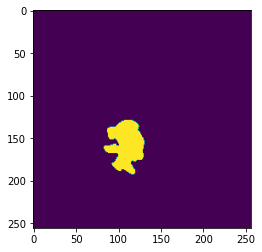

In [ ]:
plt.imshow(msk_val_batch[0,:,:,0].reshape(256,256))

In [ ]:
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Reshape, Lambda, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications import resnet50
#from skimage.transform import resize

In [ ]:
#from time import time
from os import path, mkdir
import argparse
import keras.backend as K
import logging
import numpy as np
import pickle

In [ ]:
def jaccard_coef(y_true, y_pred):
    smooth = 1.0
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    d = (2.0 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    jac = d/(2-d)
    return jac

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)

In [ ]:
from keras.layers import UpSampling2D, Input, Concatenate
from keras.layers import Conv2D, Activation, BatchNormalization

In [ ]:
from keras.applications import vgg16

In [ ]:
inputs = Input(shape=(256, 256, 3)) #input layer shape
#loading VGG16 model with imagenet dataset weights
encoder1 = vgg16.VGG16(input_tensor=inputs, weights="imagenet", include_top=False)
encoder1.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
#encoder
skip_connection_names = ["input_1", "block2_conv2", "block3_conv3", "block4_conv3"]
encoder_output = encoder1.get_layer("block5_conv3").output

f = [32, 64, 128, 256]
x = encoder_output
#decoder
for i in range(1, len(skip_connection_names)+1, 1):
    x_skip = encoder1.get_layer(skip_connection_names[-i]).output
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, x_skip])
        
    x = Conv2D(f[-i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
        
    x = Conv2D(f[-i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

conv10 = Conv2D(2, 1, 1)(x)

output = Flatten()(conv10)
H, W, D = (256, 256, 2)
output = Reshape((H * W, D))(output)
output = Activation('softmax')(output)
output = Reshape((256, 256, 2))(output)  # 128 x 128 x 2

def probability_positive(onehot):
    return onehot[:, :, :, 1]
output = Lambda(probability_positive)(output)
output = Reshape((256, 256, 1))(output)

def weighted_log_loss(yt, yp):
    a = yt * K.log(yp + K.epsilon())
    b = (1 - yt) * K.log(1 + K.epsilon() - yp)
    m = 5

    w = ((yt - 1) * -1) * (m - 1) + 1
    return -1 * K.mean(w * (a + b))


net = Model(inputs, output)
net.compile(optimizer=Adam(lr=0.0005),
                loss=weighted_log_loss,
                metrics=[dice_coef, jaccard_coef])

In [ ]:
net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model

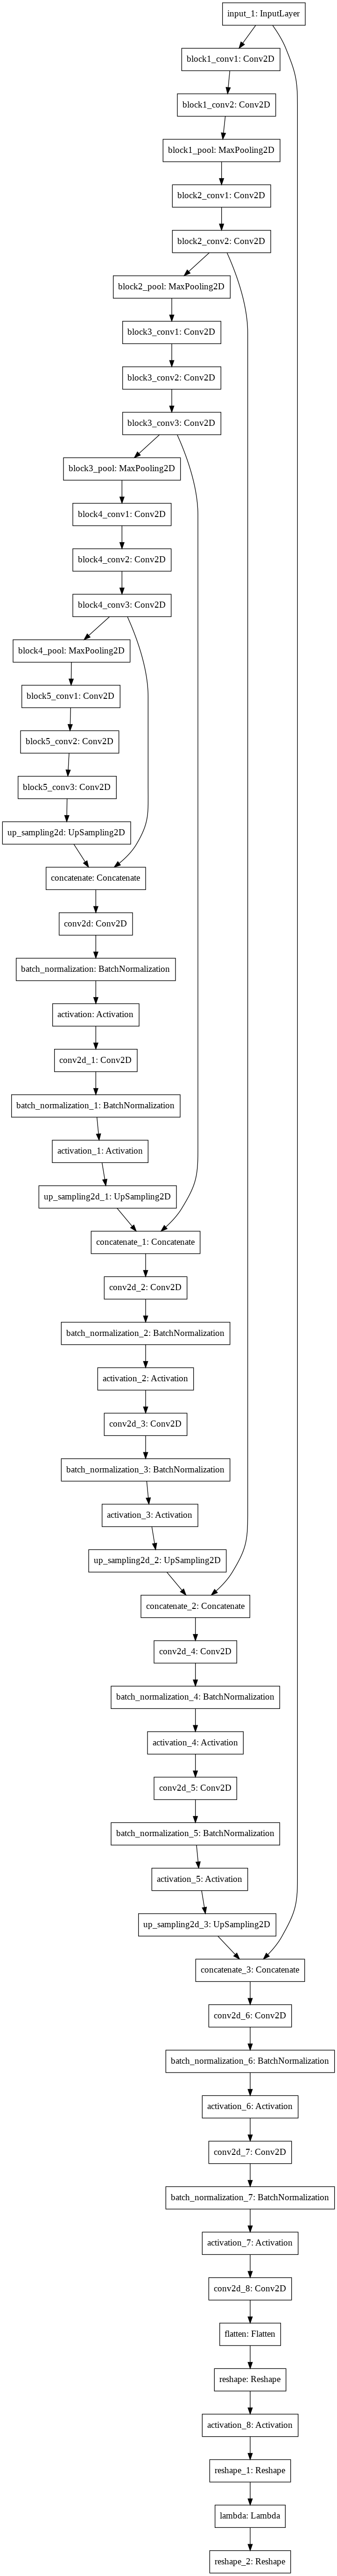

In [ ]:
plot_model(net, to_file='/content/drive/My Drive/Colab Notebooks/model.png')

In [ ]:
import sys
def funcname():
    return sys._getframe(1).f_code.co_name

In [ ]:
def train():

    logger = logging.getLogger(funcname())

    gen_trn = batch_gen1(imgs=data, msks=gt, infinite=True, re_seed=True,
                                batch_size=1)
    gen_val = batch_gen1(imgs=data, msks=gt, infinite=True, re_seed=True,
                                batch_size=1)

    cb = []
    cb.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, cooldown=3, min_lr=1e-6, verbose=1))
    cb.append(EarlyStopping(monitor='val_loss', min_delta=1e-3,
                            patience=15, verbose=1, mode='min'))
    cb.append(ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/checkpoints_transfer_learning/' + 'val_loss.net',
                                monitor='val_loss', save_best_only=True, verbose=1))
    cb.append(ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/checkpoints_transfer_learning/' + 'trn_loss.net',
                                monitor='loss', save_best_only=True, verbose=1))

    logger.info('Training for %d epochs.' % 25)

    result = net.fit_generator(
        epochs=10,
        steps_per_epoch=2048,
        generator=gen_trn,
        validation_steps=1012,
        validation_data=gen_val,
        initial_epoch=0,
        callbacks=cb,
    )


    return


In [ ]:
train()

Epoch 1/10
2048/2048 [==============================] - ETA: 0s - loss: 0.0838 - dice_coef: 0.1070 - jaccard_coef: 0.0621WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0038s vs `on_test_batch_end` time: 0.0087s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.11106, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_transfer_learning/val_loss.net
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/checkpoints_transfer_learning/val_loss.net/assets

Epoch 00001: loss improved from inf to 0.08379, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_transfer_learning/trn_loss.net
INFO:tensorflow:Assets written to: /content/dri

In [ ]:
net.load_weights('/content/drive/My Drive/Colab Notebooks/checkpoints_transfer_learning/val_loss.net/variables/variables')

In [ ]:
from math import sqrt
from keras.metrics import binary_crossentropy

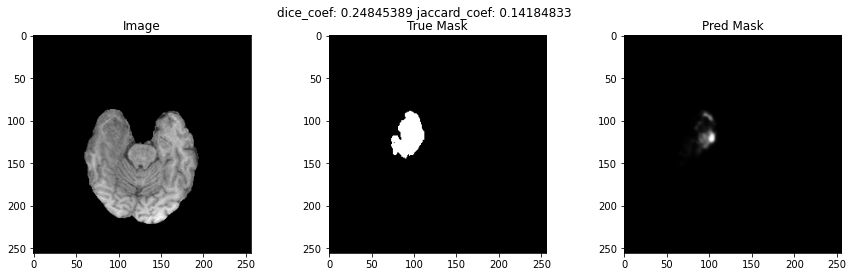

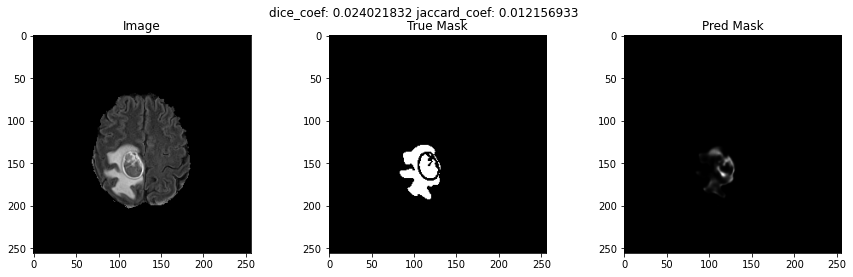

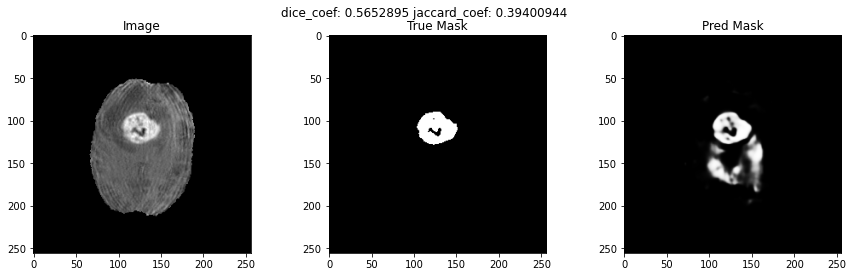

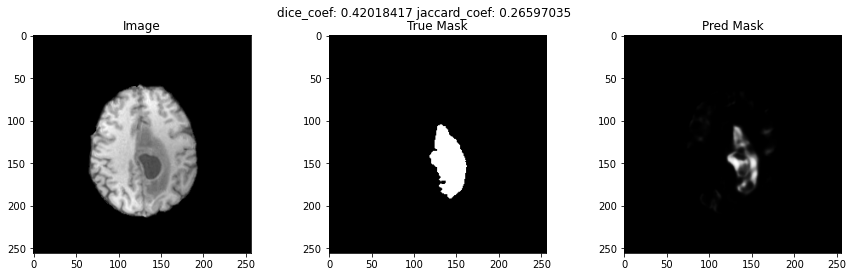

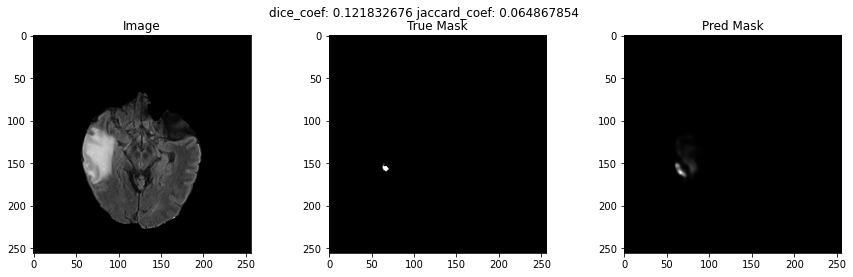

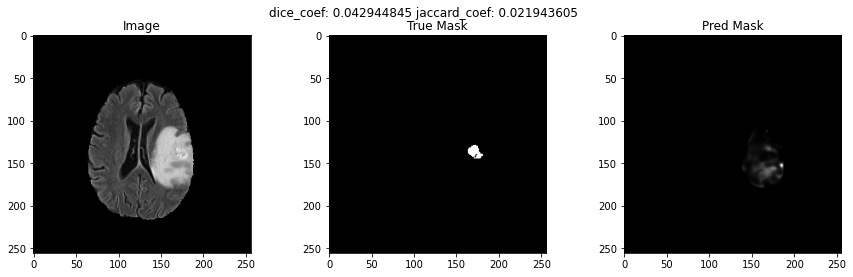

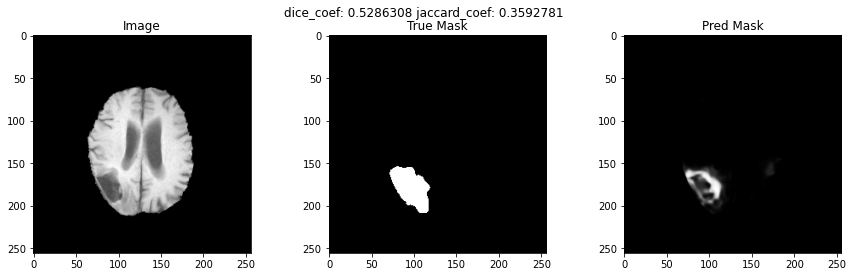

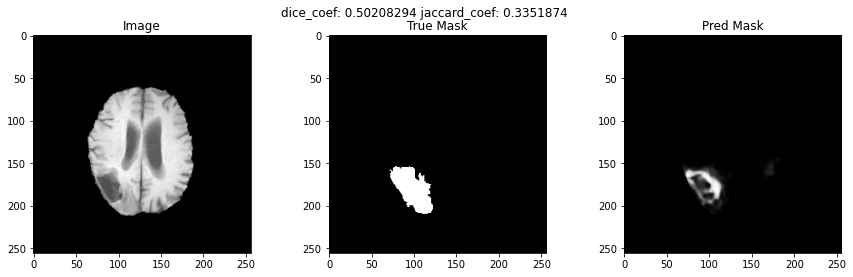

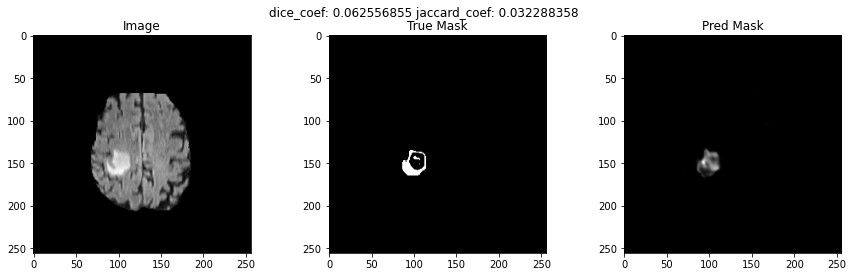

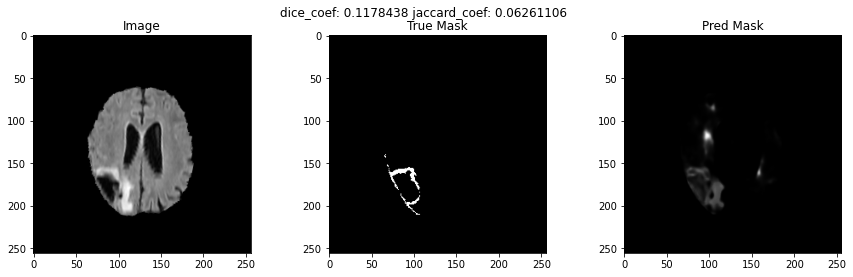

In [ ]:
# Plot predictions.
def metric_wrapper(yt, yp, metric):
    return K.get_value(metric(K.variable(yt), K.variable(yp)))

data_gen = batch_gen1(imgs=data, msks=gt, batch_size=10)
img_batch, msk_batch = next(data_gen)
prd_batch = net.predict(img_batch)
prd_batch = prd_batch

for img, msk, prd in zip(img_batch[:,:,:,0], msk_batch, prd_batch):
    r = c = int(sqrt(img.size))
    b = metric_wrapper(msk, prd, binary_crossentropy)
    d = metric_wrapper(msk, prd, dice_coef)
    j = metric_wrapper(msk, prd, jaccard_coef)
    fig,_ = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    fig.axes[0].set_title('Image')
    fig.axes[0].imshow(img.reshape(r,c), cmap='gray')
    fig.axes[1].set_title('True Mask')
    fig.axes[1].imshow(msk.reshape(r,c), cmap='gray')
    fig.axes[2].set_title('Pred Mask')
    fig.axes[2].imshow(prd.reshape(r,c), cmap='gray')
    fig.suptitle('dice_coef: '+str(d)+' jaccard_coef: '+str(j))
    plt.show()